In [ ]:
# !pip install torch
# !pip install transformers
# !pip install matplotlib
# !pip install tqdm

In [1]:
import json
from transformers import BertTokenizer, BertModel, BertForSequenceClassification, BertConfig
import torch
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
import tqdm

In [3]:
# train_data = np.load("data/SP-train.npy", allow_pickle=True)
# test_data = np.load("data/SP_eval_data_for_practice.npy", allow_pickle = True)

# train_data, val_data = train_test_split(train_data, test_size=0.15, random_state=42)
data = np.load("data/SP-train.npy", allow_pickle=True)

o_data = []
sr_data = []
cr_data = []

for i in range(len(data)):
    size_ = len(data[i]['id'])

    if data[i]['id'][size_-2:size_] == 'CR':
        cr_data.append(data[i])
    elif data[i]['id'][size_-2:size_] == 'SR':
        sr_data.append(data[i])
    else:
        o_data.append(data[i])

train_data = o_data[:int(len(o_data)*0.8)] + cr_data[:int(len(cr_data)*0.8)] + sr_data[:int(len(sr_data)*0.8)]
val_data = o_data[int(len(o_data)*0.8):int(len(o_data)*0.9)] + cr_data[int(len(cr_data)*0.8):int(len(cr_data)*0.9)] + sr_data[int(len(sr_data)*0.8):int(len(sr_data)*0.9)]
test_data = o_data[int(len(o_data)*0.9):] + cr_data[int(len(cr_data)*0.9):] + sr_data[int(len(sr_data)*0.9):]
# test_data = np.load("data/SP_eval_data_for_practice.npy", allow_pickle = True)

# train_data, val_data = train_test_split(train_data, test_size=0.15, random_state=42)

# train_questions, train_choices, train_labels = get_data_lists(train_data)
# val_questions, val_choices, val_labels = get_data_lists(val_data)
# test_questions, test_choices, test_labels = get_data_lists(test_data)

In [7]:
torch.set_default_dtype(torch.float32)

print(train_data[0])
train_data = np.array(train_data)
val_data = np.array(val_data)
test_data = np.array(test_data)
print("--------------------------------")
print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

{'id': 'SP-0', 'question': 'Mr. and Mrs. Mustard have six daughters and each daughter has one brother. But there are only 9 people in the family, how is that possible?', 'answer': 'Each daughter shares the same brother.', 'distractor1': 'Some daughters get married and have their own family.', 'distractor2': 'Some brothers were not loved by family and moved away.', 'distractor(unsure)': 'None of above.', 'label': 1, 'choice_list': ['Some daughters get married and have their own family.', 'Each daughter shares the same brother.', 'Some brothers were not loved by family and moved away.', 'None of above.'], 'choice_order': [1, 0, 2, 3]}
--------------------------------
(405,)
(51,)
(51,)


In [8]:
class Glove_Tokenizer:
    def __init__(self, GloVe_path, embedding_size):
        self.embeddings = {}
        self.GloVe_path = GloVe_path
        self.embedding_size = embedding_size
        self.embeddings = self.load_embeddings()

    def load_embeddings(self):
        embeddings = {}
        with open(self.GloVe_path, 'r', encoding='utf-8') as f:
            for line in f:
                values = line.split()
                word = values[0]
                vector = np.asarray(values[1:], dtype='float64')
                embeddings[word] = vector
        return embeddings

    def get_word_embedding(self, word):
        try:
            return self.embeddings[word]
        except:
            return np.zeros(self.embedding_size)
        
    def get_sentence_embedding(self, sentence):
        words = sentence.split(' ')
        length = len(words)
        embedding = np.zeros(self.embedding_size)
        for word in words:
            embedding += self.get_word_embedding(word)
        #print(embedding)
        return embedding / length

In [9]:
class Brain_Teaser_2(Dataset):
    def __init__(self, tokenizer, data):
        #Lists for storing data
        self.questions = []
        self.choices = []
        self.labels = []
        #instance of tokeniser and data
        self.tokenizer = tokenizer
        self.data = data
        #encoded data
        self.question_options_encoded = []
        #obtaining encoded data
        self.get_data_lists()
        self.build_questions_embedding()

    def get_data_lists(self):
        questions = []
        choices = []
        labels = []
        for example in self.data:
            questions.append(example['question'])
            choices.append(example['choice_list'])
            labels.append(example['label'])
        self.questions = questions
        self.choices = choices
        self.labels = labels

    def build_questions_embedding(self):
        maxi = 0
        for id in range(len(self.questions)):
            question_options = "Question : " + self.questions[id] + ' ' + "Options:" + ' ' + ' 0 '+ self.choices[id][0] + '1 '+ self.choices[id][1] + ' 2 '+ self.choices[id][2] + ' 3 '+ self.choices[id][3]
            maxi = max(maxi, len(question_options.split(' ')))
            self.question_options_encoded.append(self.tokenizer.get_sentence_embedding(question_options))

    def __len__(self):
        return len(self.question_options_encoded)

    def __getitem__(self, id):
        return self.question_options_encoded[id],  self.labels[id]

In [10]:
class GRUModel(nn.Module):
    def __init__(self, embedding_dim, output_size):
        super(GRUModel, self).__init__()
        self.gru1 = nn.GRU(embedding_dim, 256, num_layers=1, batch_first=True)
        self.gru2 = nn.GRU(256, 64, num_layers=1, batch_first=True)
        self.gru3 = nn.GRU(64, 16, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(16, output_size)

    def forward(self, x):
        out, _ = self.gru1(x)
        out, _ = self.gru2(out)
        out, _ = self.gru3(out)
        out = self.fc1(out)   
        return out
    
class RNNModel(nn.Module):
    def __init__(self, embedding_dim, output_size):
        super(RNNModel, self).__init__()
        self.rnn_1 = nn.RNN(embedding_dim, 256, num_layers=1,batch_first=True)
        self.rnn_2 = nn.RNN(256, 64, num_layers=1,batch_first=True)
        self.fc_1 = nn.Linear(64, 16)
        self.fc_2 = nn.Linear(16, output_size)

    def forward(self, x):
        out, _ = self.rnn_1(x)  
        out, _ = self.rnn_2(out)              
        out = self.fc_1(out)
        out = self.fc_2(out)
        return out

In [11]:
#define tokenizer with file and embedding size
glove_tokenizer = Glove_Tokenizer('Glove_files/glove.6B.50d.txt',50)

In [12]:
#defining training and validation dataset
train_dataset = Brain_Teaser_2(glove_tokenizer, train_data)
val_dataset = Brain_Teaser_2(glove_tokenizer, val_data)
test_dataset = Brain_Teaser_2(glove_tokenizer, test_data)

  0%|          | 0/51 [00:00<?, ?it/s]C:\Users\Shobhit\AppData\Local\Temp\ipykernel_5376\396184966.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32)
100%|██████████| 51/51 [00:00<00:00, 88.16it/s] 
C:\Users\Shobhit\AppData\Local\Temp\ipykernel_5376\396184966.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32)


Epoch [1/50], Train Loss: 1.2878, Train Accuracy: 29.88% , Val Loss: 1.3069, Val Accuracy: 31.37%


100%|██████████| 51/51 [00:00<00:00, 222.05it/s]


Epoch [2/50], Train Loss: 1.2617, Train Accuracy: 33.58% , Val Loss: 1.3654, Val Accuracy: 33.33%


100%|██████████| 51/51 [00:00<00:00, 238.31it/s]


Epoch [3/50], Train Loss: 1.2666, Train Accuracy: 33.09% , Val Loss: 1.3521, Val Accuracy: 31.37%


100%|██████████| 51/51 [00:00<00:00, 228.70it/s]


Epoch [4/50], Train Loss: 1.2588, Train Accuracy: 30.86% , Val Loss: 1.3715, Val Accuracy: 31.37%


100%|██████████| 51/51 [00:00<00:00, 232.86it/s]


Epoch [5/50], Train Loss: 1.2553, Train Accuracy: 34.81% , Val Loss: 1.3326, Val Accuracy: 31.37%


100%|██████████| 51/51 [00:00<00:00, 239.44it/s]


Epoch [6/50], Train Loss: 1.2569, Train Accuracy: 29.38% , Val Loss: 1.3736, Val Accuracy: 27.45%


100%|██████████| 51/51 [00:00<00:00, 226.66it/s]


Epoch [7/50], Train Loss: 1.2409, Train Accuracy: 32.59% , Val Loss: 1.3195, Val Accuracy: 23.53%


100%|██████████| 51/51 [00:00<00:00, 237.21it/s]


Epoch [8/50], Train Loss: 1.2357, Train Accuracy: 32.35% , Val Loss: 1.3090, Val Accuracy: 23.53%


100%|██████████| 51/51 [00:00<00:00, 226.67it/s]


Epoch [9/50], Train Loss: 1.1955, Train Accuracy: 33.33% , Val Loss: 1.2846, Val Accuracy: 33.33%


100%|██████████| 51/51 [00:00<00:00, 220.78it/s]


Epoch [10/50], Train Loss: 1.1835, Train Accuracy: 38.77% , Val Loss: 1.2468, Val Accuracy: 27.45%


100%|██████████| 51/51 [00:00<00:00, 233.22it/s]


Epoch [11/50], Train Loss: 1.1672, Train Accuracy: 38.02% , Val Loss: 1.3468, Val Accuracy: 31.37%


100%|██████████| 51/51 [00:00<00:00, 211.39it/s]


Epoch [12/50], Train Loss: 1.1602, Train Accuracy: 37.04% , Val Loss: 1.2917, Val Accuracy: 31.37%


100%|██████████| 51/51 [00:00<00:00, 232.87it/s]


Epoch [13/50], Train Loss: 1.1507, Train Accuracy: 35.31% , Val Loss: 1.3015, Val Accuracy: 37.25%


100%|██████████| 51/51 [00:00<00:00, 219.82it/s]


Epoch [14/50], Train Loss: 1.1524, Train Accuracy: 36.79% , Val Loss: 1.2540, Val Accuracy: 37.25%


100%|██████████| 51/51 [00:00<00:00, 220.77it/s]


Epoch [15/50], Train Loss: 1.1416, Train Accuracy: 38.02% , Val Loss: 1.2268, Val Accuracy: 33.33%


100%|██████████| 51/51 [00:00<00:00, 224.67it/s]


Epoch [16/50], Train Loss: 1.1379, Train Accuracy: 37.78% , Val Loss: 1.2937, Val Accuracy: 33.33%


100%|██████████| 51/51 [00:00<00:00, 233.95it/s]


Epoch [17/50], Train Loss: 1.1343, Train Accuracy: 36.79% , Val Loss: 1.2631, Val Accuracy: 27.45%


100%|██████████| 51/51 [00:00<00:00, 241.72it/s]


Epoch [18/50], Train Loss: 1.1281, Train Accuracy: 40.00% , Val Loss: 1.3441, Val Accuracy: 31.37%


100%|██████████| 51/51 [00:00<00:00, 223.66it/s]


Epoch [19/50], Train Loss: 1.1193, Train Accuracy: 40.74% , Val Loss: 1.2823, Val Accuracy: 33.33%


100%|██████████| 51/51 [00:00<00:00, 241.26it/s]


Epoch [20/50], Train Loss: 1.1219, Train Accuracy: 37.04% , Val Loss: 1.2834, Val Accuracy: 33.33%


100%|██████████| 51/51 [00:00<00:00, 240.36it/s]


Epoch [21/50], Train Loss: 1.1170, Train Accuracy: 41.48% , Val Loss: 1.2333, Val Accuracy: 37.25%


100%|██████████| 51/51 [00:00<00:00, 239.44it/s]


Epoch [22/50], Train Loss: 1.1183, Train Accuracy: 37.78% , Val Loss: 1.3390, Val Accuracy: 33.33%


100%|██████████| 51/51 [00:00<00:00, 244.01it/s]


Epoch [23/50], Train Loss: 1.1123, Train Accuracy: 40.99% , Val Loss: 1.3469, Val Accuracy: 35.29%


100%|██████████| 51/51 [00:00<00:00, 245.18it/s]


Epoch [24/50], Train Loss: 1.1088, Train Accuracy: 39.26% , Val Loss: 1.3231, Val Accuracy: 35.29%


100%|██████████| 51/51 [00:00<00:00, 226.66it/s]


Epoch [25/50], Train Loss: 1.1055, Train Accuracy: 40.74% , Val Loss: 1.2954, Val Accuracy: 37.25%


100%|██████████| 51/51 [00:00<00:00, 238.31it/s]


Epoch [26/50], Train Loss: 1.0955, Train Accuracy: 39.75% , Val Loss: 1.3084, Val Accuracy: 33.33%


100%|██████████| 51/51 [00:00<00:00, 239.43it/s]


Epoch [27/50], Train Loss: 1.0959, Train Accuracy: 40.25% , Val Loss: 1.4243, Val Accuracy: 31.37%


100%|██████████| 51/51 [00:00<00:00, 238.31it/s]


Epoch [28/50], Train Loss: 1.0890, Train Accuracy: 41.98% , Val Loss: 1.3166, Val Accuracy: 37.25%


100%|██████████| 51/51 [00:00<00:00, 235.03it/s]


Epoch [29/50], Train Loss: 1.1003, Train Accuracy: 38.52% , Val Loss: 1.3389, Val Accuracy: 31.37%


100%|██████████| 51/51 [00:00<00:00, 219.96it/s]


Epoch [30/50], Train Loss: 1.0818, Train Accuracy: 43.95% , Val Loss: 1.3110, Val Accuracy: 31.37%


100%|██████████| 51/51 [00:00<00:00, 238.31it/s]


Epoch [31/50], Train Loss: 1.0872, Train Accuracy: 43.70% , Val Loss: 1.3229, Val Accuracy: 27.45%


100%|██████████| 51/51 [00:00<00:00, 238.31it/s]


Epoch [32/50], Train Loss: 1.0808, Train Accuracy: 43.46% , Val Loss: 1.3261, Val Accuracy: 33.33%


100%|██████████| 51/51 [00:00<00:00, 245.19it/s]


Epoch [33/50], Train Loss: 1.0772, Train Accuracy: 41.23% , Val Loss: 1.2961, Val Accuracy: 31.37%


100%|██████████| 51/51 [00:00<00:00, 239.43it/s]


Epoch [34/50], Train Loss: 1.0806, Train Accuracy: 42.96% , Val Loss: 1.3142, Val Accuracy: 35.29%


100%|██████████| 51/51 [00:00<00:00, 241.71it/s]


Epoch [35/50], Train Loss: 1.0819, Train Accuracy: 41.23% , Val Loss: 1.3163, Val Accuracy: 27.45%


100%|██████████| 51/51 [00:00<00:00, 245.19it/s]


Epoch [36/50], Train Loss: 1.0759, Train Accuracy: 41.48% , Val Loss: 1.3316, Val Accuracy: 27.45%


100%|██████████| 51/51 [00:00<00:00, 230.76it/s]


Epoch [37/50], Train Loss: 1.0838, Train Accuracy: 41.73% , Val Loss: 1.2891, Val Accuracy: 41.18%


100%|██████████| 51/51 [00:00<00:00, 227.67it/s]


Epoch [38/50], Train Loss: 1.0813, Train Accuracy: 42.96% , Val Loss: 1.4051, Val Accuracy: 29.41%


100%|██████████| 51/51 [00:00<00:00, 208.21it/s]


Epoch [39/50], Train Loss: 1.0750, Train Accuracy: 43.21% , Val Loss: 1.3241, Val Accuracy: 35.29%


100%|██████████| 51/51 [00:00<00:00, 236.09it/s]


Epoch [40/50], Train Loss: 1.0741, Train Accuracy: 45.43% , Val Loss: 1.3030, Val Accuracy: 35.29%


100%|██████████| 51/51 [00:00<00:00, 240.56it/s]


Epoch [41/50], Train Loss: 1.0698, Train Accuracy: 44.20% , Val Loss: 1.3389, Val Accuracy: 29.41%


100%|██████████| 51/51 [00:00<00:00, 235.39it/s]


Epoch [42/50], Train Loss: 1.0746, Train Accuracy: 41.73% , Val Loss: 1.3673, Val Accuracy: 27.45%


100%|██████████| 51/51 [00:00<00:00, 242.48it/s]


Epoch [43/50], Train Loss: 1.0733, Train Accuracy: 44.44% , Val Loss: 1.4166, Val Accuracy: 29.41%


100%|██████████| 51/51 [00:00<00:00, 236.15it/s]


Epoch [44/50], Train Loss: 1.0676, Train Accuracy: 45.43% , Val Loss: 1.4042, Val Accuracy: 43.14%


100%|██████████| 51/51 [00:00<00:00, 239.45it/s]


Epoch [45/50], Train Loss: 1.0691, Train Accuracy: 42.96% , Val Loss: 1.3905, Val Accuracy: 23.53%


100%|██████████| 51/51 [00:00<00:00, 246.37it/s]


Epoch [46/50], Train Loss: 1.0637, Train Accuracy: 43.95% , Val Loss: 1.3338, Val Accuracy: 33.33%


100%|██████████| 51/51 [00:00<00:00, 237.17it/s]


Epoch [47/50], Train Loss: 1.0595, Train Accuracy: 42.22% , Val Loss: 1.3673, Val Accuracy: 33.33%


100%|██████████| 51/51 [00:00<00:00, 238.32it/s]


Epoch [48/50], Train Loss: 1.0589, Train Accuracy: 45.68% , Val Loss: 1.3163, Val Accuracy: 31.37%


100%|██████████| 51/51 [00:00<00:00, 216.17it/s]


Epoch [49/50], Train Loss: 1.0623, Train Accuracy: 44.20% , Val Loss: 1.3670, Val Accuracy: 29.41%


100%|██████████| 51/51 [00:00<00:00, 238.32it/s]


Epoch [50/50], Train Loss: 1.0584, Train Accuracy: 45.43% , Val Loss: 1.4088, Val Accuracy: 33.33%


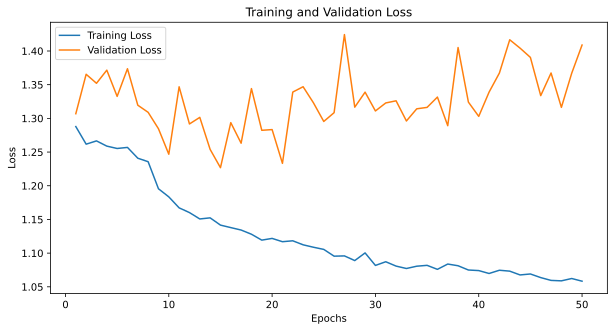

In [13]:
def train(train_dataset, val_dataset, model, epochs=5, learning_rate=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True)
    
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        t_correct = 0
        t_total = 0
        for inputs, targets in tqdm.tqdm(train_dataloader):
            inputs = torch.tensor(inputs, dtype=torch.float32)
            inputs = inputs.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            _, predicted = torch.max(outputs, 1)
            t_total += targets.size(0)
            t_correct += (predicted == targets).sum().item()
        
        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, targets in val_dataloader:
                inputs = torch.tensor(inputs, dtype=torch.float32)
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

        train_loss = running_loss / len(train_dataloader)
        val_loss = val_loss / len(val_dataloader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch [{epoch+1}/{epochs}], "
              f"Train Loss: {train_loss:.4f}, "
                f"Train Accuracy: {(100 * t_correct / t_total):.2f}% , "
              f"Val Loss: {val_loss:.4f}, "
              f"Val Accuracy: {(100 * correct / total):.2f}%")

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
# Example usage:
model = GRUModel(50, 4)
train(train_dataset, val_dataset, model, epochs=50)

  0%|          | 0/51 [00:00<?, ?it/s]C:\Users\Shobhit\AppData\Local\Temp\ipykernel_5376\396184966.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32)
100%|██████████| 51/51 [00:00<00:00, 133.17it/s]
C:\Users\Shobhit\AppData\Local\Temp\ipykernel_5376\396184966.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32)


Epoch [1/50], Train Loss: 1.2723, Train Accuracy: 34.57% , Val Loss: 1.3369, Val Accuracy: 23.53%


100%|██████████| 51/51 [00:00<00:00, 238.32it/s]


Epoch [2/50], Train Loss: 1.2537, Train Accuracy: 33.58% , Val Loss: 1.3146, Val Accuracy: 31.37%


100%|██████████| 51/51 [00:00<00:00, 275.68it/s]


Epoch [3/50], Train Loss: 1.2195, Train Accuracy: 32.59% , Val Loss: 1.3728, Val Accuracy: 23.53%


100%|██████████| 51/51 [00:00<00:00, 289.77it/s]


Epoch [4/50], Train Loss: 1.1939, Train Accuracy: 35.80% , Val Loss: 1.2086, Val Accuracy: 27.45%


100%|██████████| 51/51 [00:00<00:00, 293.10it/s]


Epoch [5/50], Train Loss: 1.1639, Train Accuracy: 38.52% , Val Loss: 1.2459, Val Accuracy: 35.29%


100%|██████████| 51/51 [00:00<00:00, 294.80it/s]


Epoch [6/50], Train Loss: 1.1506, Train Accuracy: 38.02% , Val Loss: 1.2357, Val Accuracy: 27.45%


100%|██████████| 51/51 [00:00<00:00, 281.79it/s]


Epoch [7/50], Train Loss: 1.1831, Train Accuracy: 35.31% , Val Loss: 1.3276, Val Accuracy: 23.53%


100%|██████████| 51/51 [00:00<00:00, 267.43it/s]


Epoch [8/50], Train Loss: 1.1718, Train Accuracy: 33.09% , Val Loss: 1.2492, Val Accuracy: 29.41%


100%|██████████| 51/51 [00:00<00:00, 271.28it/s]


Epoch [9/50], Train Loss: 1.1415, Train Accuracy: 38.77% , Val Loss: 1.2711, Val Accuracy: 33.33%


100%|██████████| 51/51 [00:00<00:00, 255.00it/s]


Epoch [10/50], Train Loss: 1.1206, Train Accuracy: 36.54% , Val Loss: 1.3711, Val Accuracy: 29.41%


100%|██████████| 51/51 [00:00<00:00, 257.58it/s]


Epoch [11/50], Train Loss: 1.1381, Train Accuracy: 36.79% , Val Loss: 1.2982, Val Accuracy: 37.25%


100%|██████████| 51/51 [00:00<00:00, 275.68it/s]


Epoch [12/50], Train Loss: 1.1295, Train Accuracy: 38.02% , Val Loss: 1.2632, Val Accuracy: 31.37%


100%|██████████| 51/51 [00:00<00:00, 274.19it/s]


Epoch [13/50], Train Loss: 1.1312, Train Accuracy: 35.06% , Val Loss: 1.2881, Val Accuracy: 25.49%


100%|██████████| 51/51 [00:00<00:00, 269.84it/s]


Epoch [14/50], Train Loss: 1.1146, Train Accuracy: 40.49% , Val Loss: 1.2772, Val Accuracy: 25.49%


100%|██████████| 51/51 [00:00<00:00, 260.20it/s]


Epoch [15/50], Train Loss: 1.1258, Train Accuracy: 39.01% , Val Loss: 1.2529, Val Accuracy: 23.53%


100%|██████████| 51/51 [00:00<00:00, 281.77it/s]


Epoch [16/50], Train Loss: 1.1400, Train Accuracy: 37.28% , Val Loss: 1.3990, Val Accuracy: 37.25%


100%|██████████| 51/51 [00:00<00:00, 281.77it/s]


Epoch [17/50], Train Loss: 1.1163, Train Accuracy: 41.73% , Val Loss: 1.2434, Val Accuracy: 33.33%


100%|██████████| 51/51 [00:00<00:00, 235.86it/s]


Epoch [18/50], Train Loss: 1.1423, Train Accuracy: 39.51% , Val Loss: 1.3146, Val Accuracy: 25.49%


100%|██████████| 51/51 [00:00<00:00, 255.62it/s]


Epoch [19/50], Train Loss: 1.1178, Train Accuracy: 40.00% , Val Loss: 1.2228, Val Accuracy: 35.29%


100%|██████████| 51/51 [00:00<00:00, 255.00it/s]


Epoch [20/50], Train Loss: 1.1199, Train Accuracy: 37.04% , Val Loss: 1.2573, Val Accuracy: 27.45%


100%|██████████| 51/51 [00:00<00:00, 250.00it/s]


Epoch [21/50], Train Loss: 1.1184, Train Accuracy: 36.30% , Val Loss: 1.3244, Val Accuracy: 25.49%


100%|██████████| 51/51 [00:00<00:00, 272.73it/s]


Epoch [22/50], Train Loss: 1.1147, Train Accuracy: 37.53% , Val Loss: 1.2998, Val Accuracy: 31.37%


100%|██████████| 51/51 [00:00<00:00, 260.21it/s]


Epoch [23/50], Train Loss: 1.1131, Train Accuracy: 40.49% , Val Loss: 1.3164, Val Accuracy: 31.37%


100%|██████████| 51/51 [00:00<00:00, 284.92it/s]


Epoch [24/50], Train Loss: 1.1122, Train Accuracy: 43.46% , Val Loss: 1.3122, Val Accuracy: 33.33%


100%|██████████| 51/51 [00:00<00:00, 264.25it/s]


Epoch [25/50], Train Loss: 1.0961, Train Accuracy: 40.25% , Val Loss: 1.2856, Val Accuracy: 31.37%


100%|██████████| 51/51 [00:00<00:00, 291.43it/s]


Epoch [26/50], Train Loss: 1.1091, Train Accuracy: 43.46% , Val Loss: 1.3306, Val Accuracy: 35.29%


100%|██████████| 51/51 [00:00<00:00, 294.79it/s]

Epoch [27/50], Train Loss: 1.1023, Train Accuracy: 39.75% , Val Loss: 1.2533, Val Accuracy: 29.41%



100%|██████████| 51/51 [00:00<00:00, 260.20it/s]


Epoch [28/50], Train Loss: 1.0767, Train Accuracy: 45.43% , Val Loss: 1.3084, Val Accuracy: 35.29%


100%|██████████| 51/51 [00:00<00:00, 242.13it/s]


Epoch [29/50], Train Loss: 1.0840, Train Accuracy: 40.00% , Val Loss: 1.4750, Val Accuracy: 33.33%


100%|██████████| 51/51 [00:00<00:00, 255.00it/s]


Epoch [30/50], Train Loss: 1.1012, Train Accuracy: 40.99% , Val Loss: 1.4142, Val Accuracy: 41.18%


100%|██████████| 51/51 [00:00<00:00, 250.00it/s]


Epoch [31/50], Train Loss: 1.0892, Train Accuracy: 42.47% , Val Loss: 1.3427, Val Accuracy: 33.33%


100%|██████████| 51/51 [00:00<00:00, 241.70it/s]


Epoch [32/50], Train Loss: 1.1208, Train Accuracy: 40.99% , Val Loss: 1.5638, Val Accuracy: 29.41%


100%|██████████| 51/51 [00:00<00:00, 240.56it/s]


Epoch [33/50], Train Loss: 1.1060, Train Accuracy: 40.99% , Val Loss: 1.2925, Val Accuracy: 31.37%


100%|██████████| 51/51 [00:00<00:00, 237.21it/s]


Epoch [34/50], Train Loss: 1.0786, Train Accuracy: 45.93% , Val Loss: 1.2684, Val Accuracy: 33.33%


100%|██████████| 51/51 [00:00<00:00, 240.57it/s]


Epoch [35/50], Train Loss: 1.0667, Train Accuracy: 43.70% , Val Loss: 1.3094, Val Accuracy: 37.25%


100%|██████████| 51/51 [00:00<00:00, 235.02it/s]


Epoch [36/50], Train Loss: 1.1149, Train Accuracy: 41.48% , Val Loss: 1.3456, Val Accuracy: 31.37%


100%|██████████| 51/51 [00:00<00:00, 213.39it/s]


Epoch [37/50], Train Loss: 1.0810, Train Accuracy: 44.94% , Val Loss: 1.3570, Val Accuracy: 35.29%


100%|██████████| 51/51 [00:00<00:00, 241.27it/s]


Epoch [38/50], Train Loss: 1.0710, Train Accuracy: 43.95% , Val Loss: 1.3061, Val Accuracy: 39.22%


100%|██████████| 51/51 [00:00<00:00, 239.70it/s]


Epoch [39/50], Train Loss: 1.0774, Train Accuracy: 46.17% , Val Loss: 1.3384, Val Accuracy: 31.37%


100%|██████████| 51/51 [00:00<00:00, 227.68it/s]


Epoch [40/50], Train Loss: 1.0788, Train Accuracy: 44.20% , Val Loss: 1.2738, Val Accuracy: 29.41%


100%|██████████| 51/51 [00:00<00:00, 229.73it/s]


Epoch [41/50], Train Loss: 1.0725, Train Accuracy: 43.21% , Val Loss: 1.3161, Val Accuracy: 35.29%


100%|██████████| 51/51 [00:00<00:00, 241.71it/s]


Epoch [42/50], Train Loss: 1.0722, Train Accuracy: 45.68% , Val Loss: 1.2911, Val Accuracy: 39.22%


100%|██████████| 51/51 [00:00<00:00, 235.02it/s]


Epoch [43/50], Train Loss: 1.0860, Train Accuracy: 42.72% , Val Loss: 1.6506, Val Accuracy: 25.49%


100%|██████████| 51/51 [00:00<00:00, 240.57it/s]


Epoch [44/50], Train Loss: 1.0605, Train Accuracy: 43.95% , Val Loss: 1.4047, Val Accuracy: 31.37%


100%|██████████| 51/51 [00:00<00:00, 235.02it/s]


Epoch [45/50], Train Loss: 1.0774, Train Accuracy: 41.23% , Val Loss: 1.3764, Val Accuracy: 33.33%


100%|██████████| 51/51 [00:00<00:00, 220.78it/s]


Epoch [46/50], Train Loss: 1.0667, Train Accuracy: 45.19% , Val Loss: 1.3808, Val Accuracy: 31.37%


100%|██████████| 51/51 [00:00<00:00, 228.70it/s]


Epoch [47/50], Train Loss: 1.0841, Train Accuracy: 46.67% , Val Loss: 1.3135, Val Accuracy: 27.45%


100%|██████████| 51/51 [00:00<00:00, 229.77it/s]


Epoch [48/50], Train Loss: 1.0660, Train Accuracy: 46.91% , Val Loss: 1.3017, Val Accuracy: 33.33%


100%|██████████| 51/51 [00:00<00:00, 255.00it/s]


Epoch [49/50], Train Loss: 1.0580, Train Accuracy: 46.42% , Val Loss: 1.4124, Val Accuracy: 35.29%


100%|██████████| 51/51 [00:00<00:00, 263.10it/s]

Epoch [50/50], Train Loss: 1.0641, Train Accuracy: 47.41% , Val Loss: 1.3821, Val Accuracy: 33.33%


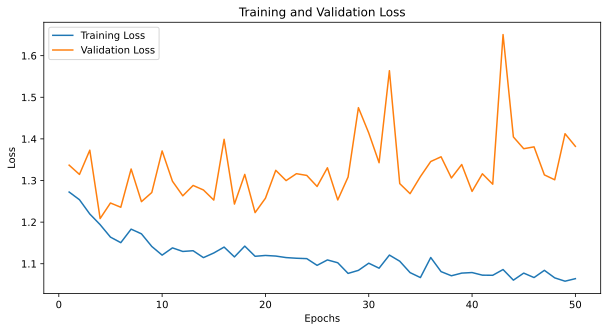

In [14]:
model_RNN = RNNModel(50, 4)
train(train_dataset, val_dataset, model_RNN, epochs=50)

In [21]:
#testing the models
def test(model, test_dataset):
    test_loss = 0.0
    correct = 0
    total = 0
    test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    criterion = nn.CrossEntropyLoss()
    model.to(device)
    with torch.no_grad():
        for inputs, targets in test_dataloader:
            inputs = torch.tensor(inputs, dtype=torch.float32)
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    test_loss = test_loss / len(test_dataloader)
    print(f"Test Loss: {test_loss:.4f}, "
          f"Test Accuracy: {(100 * correct / total):.2f}%")
    
test(model, test_dataset)
test(model_RNN, test_dataset)

Test Loss: 1.6771, Test Accuracy: 21.57%
Test Loss: 1.7948, Test Accuracy: 35.29%


C:\Users\Shobhit\AppData\Local\Temp\ipykernel_5376\3908693245.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32)
